In [97]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [77]:
df = pd.read_csv("elektrisitet-1.csv", delimiter=";", encoding="latin1")
df["Elektrisk kraft"] = df["Elektrisk kraft"].replace("..", np.nan)
df = df.pivot_table(index="måned", values="Elektrisk kraft", columns="produksjon og forbruk", aggfunc="first")
df.reset_index(inplace=True)
df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric)

In [82]:
df

produksjon og forbruk,måned,1 Total produksjon av elektrisk kraft,2 Import,3 Eksport,4 Bruttoforbruk av elektrisk kraft,6 Nettap og statistisk differanse,7 Nettoforbruk av elektrisk kraft
0,1993M01,11718176,42135,459820,11300491,NaN,NaN
1,1993M02,10675869,35271,466053,10245087,NaN,NaN
2,1993M03,11406111,35198,564604,10876705,NaN,NaN
3,1993M04,9464337,40041,660249,8844129,NaN,NaN
4,1993M05,8339679,25683,599141,7766221,NaN,NaN
...,...,...,...,...,...,...,...
381,2024M10,12878212,1281038,2697042,11462208,568672.0,10809647.0
382,2024M11,14743252,1002181,3041763,12703670,684839.0,11957294.0
383,2024M12,15846494,1103533,3150466,13799561,763298.0,12945144.0
384,2025M01,17367736,849279,3464021,14752994,913092.0,13803710.0


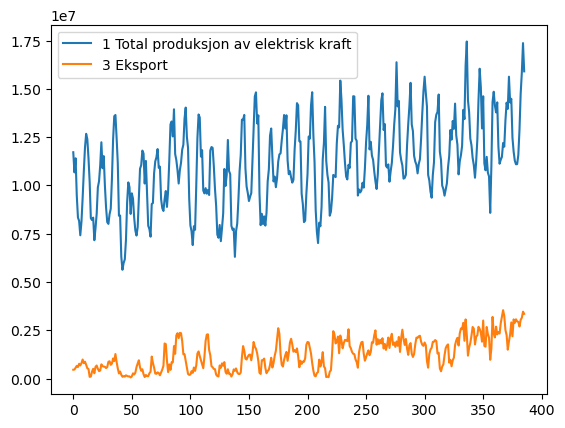

In [99]:
df["1 Total produksjon av elektrisk kraft"].plot()
# df["2 Import"].plot()
df["3 Eksport"].plot()
# df["4 Bruttoforbruk av elektrisk kraft"].plot()
# df["6 Nettap og statistisk differanse"].plot()
# df["7 Nettoforbruk av elektrisk kraft"].plot()
plt.legend()